In [1]:
import math
from inspect import isfunction
from functools import partial

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from Unet import *
from DiffusionModel import *

In [2]:
# define hyperparameters

image_size = 32
channel = 1

batchsize = 256

timestep = 1000
length = 100

lr = 1e-3
epochs = 5

dimmults = (1,2,4,8)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(device)

cuda:0


In [3]:
# get MNIST datasets

data_root = './data'

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5),
])

train_set = datasets.MNIST(
    root=data_root, train=True, download=True, transform=transform
)

data_loader = DataLoader(train_set, batch_size=batchsize, shuffle=True)

In [4]:
# define linear beta schedule

linear_betas, linear_alphas, linear_sqrt_alphas, linear_sqrt_one_minus_alphas, linear_sampling_1, linear_sampling_2 = total_beta_schedule(linear_beta_schedule, timestep)

# define linear network and optimizer_linear

linear_net = Unet(
    dim=image_size,
    channels=channel,
    dim_mults=dimmults
)
linear_net.to(device)

linear_optimizer = optim.Adam(linear_net.parameters(), lr=lr)

In [5]:
# train - linear

linear_training_loss, linear_training_taken_step, linear_taken_step = training(data_loader, epochs, timestep, linear_net, linear_optimizer, device, 
                                                                               linear_sqrt_alphas, linear_sqrt_one_minus_alphas)

>> epoch : 0
Loss:  0.058331459760665894
Loss:  0.041424915194511414
>> epoch : 1
Loss:  0.02332722768187523
Loss:  0.031225502490997314
>> epoch : 2
Loss:  0.024319950491189957
Loss:  0.02493092231452465
Loss:  0.020345870405435562
>> epoch : 3
Loss:  0.019917182624340057
Loss:  0.0226982943713665
>> epoch : 4
Loss:  0.02131558768451214
Loss:  0.02346712537109852


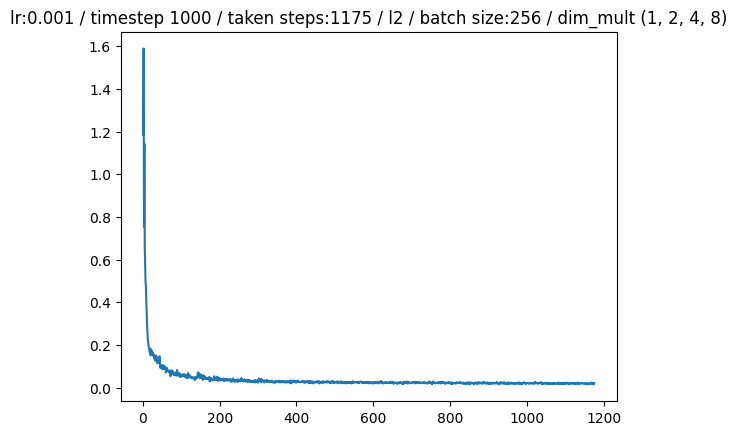

In [6]:
# plot loss linear 

x = np.array(linear_training_taken_step)
y = np.array([x.cpu().detach().numpy() for x in linear_training_loss])

plt.plot(x, y)
plt.title(f"lr:{lr} / timestep {timestep} / taken steps:{linear_taken_step} / l2 / batch size:{batchsize} / dim_mult {dimmults}")
plt.show()

In [7]:
# save linear model
save_net_betas(linear_net,
               linear_betas, 
               linear_alphas,
               linear_sqrt_alphas,
               linear_sqrt_one_minus_alphas,
               linear_sampling_1, 
               linear_sampling_2, 
               "DDIM_model")